# Trabalhando com datasets

Estudaremos práticas comuns ao trabalhar com datasets

### Carregando os dados

Inicialmente utilizaremos imagens do dataset MNIST disponibilizadas pela biblioteca torchvision

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets

# Diretório no qual as imagens serão armazenadas
root = "../data"
ds_or = datasets.MNIST(root, train=True, download=True)

img, target = ds_or[0]
print(type(img))
print(target)

<class 'PIL.Image.Image'>
5


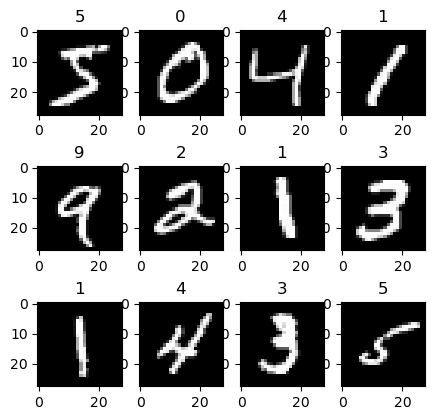

In [2]:
fig, axs = plt.subplots(3,4,figsize=(5,5))
for idx, ax in enumerate(axs.reshape(-1)):
    img, target = ds_or[idx]
    ax.imshow(img, "gray")
    ax.set_title(target)

### Extração de um subconjunto para agilizar os testes

Iremos extrair um subconjunto do MNIST. Para isso, criaremos uma *Dataset* do Pytorch contendo um subconjunto das imagens. Datasets devem herdar da classe torch.utils.data.Dataset, e devem implementar os métodos `__getitem__` e `__len__`

In [3]:
import random

class Subset(Dataset):

    def __init__(self, ds, indices):
        self.ds = ds
        self.indices = indices

    def __getitem__(self, idx):
        return self.ds[self.indices[idx]]

    def __len__(self):
        return len(self.indices)
    
# Semente do gerador de números aleatórios
random.seed(42)
# Dataset com 1000 imagens
indices = random.sample(range(len(ds_or)), k=1000)
ds = Subset(ds_or, indices)
len(ds)

1000

### Normalização dos dados

É importante que os dados de entrada de uma rede estejam normalizados para ter média 0 e desvio padrão 1. Para isso, calculamos essas estatísticas para o dataset

In [4]:
def get_statistics(ds):

    n = len(ds)
    mean = 0.
    std = 0.
    for img, target in ds:
        mean += np.mean(np.array(img))
        std += np.std(np.array(img))
    mean /= n
    std /= n

    return mean, std

mean, std = get_statistics(ds)
print(mean, std)

32.96950255102037 76.55556595768888


Precisamos também definir as transformações a serem feitas para cada imagem. Atualmente o dataset retorna imagens da classe PIL.Image, precisamos converter cada imagem para um tensor do Pytorch e normalizar os valores para média 0 e desvio padrão 1:

In [5]:
class Transform:
    """Classe para transformar as imagens de um dataset."""

    def __init__(self, mean, std):

        self.mean = mean
        self.std = std

    def __call__(self, img):
        """Transformação PIL->numpy->tensor->z-score."""

        # Conversão PIL->numpy
        img = np.array(img, dtype=np.float32)
        # Conversão numpy->pytorch
        img = torch.from_numpy(img)
        # Normalização
        img = (img-mean)/std
        # Adição de um canal
        img = img.reshape(1, img.shape[0], img.shape[1])

        return img

### Classe final

In [6]:
class Subset(Dataset):

    def __init__(self, ds, indices, transform=None):
        self.ds = ds
        self.indices = indices
        self.transform = transform

    def __getitem__(self, idx):
        """Retorna um item, opcionalmente aplicando uma transformação."""

        img, target = self.ds[self.indices[idx]]
        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.indices)
    
# Podemos criar subsets de treinamento e validação
random.seed(42)
indices = random.sample(range(len(ds_or)), k=2000)
ds_train = Subset(ds_or, indices[:1000], transform=Transform(mean, std))
ds_valid = Subset(ds_or, indices[1000:], transform=Transform(mean, std))

### Dataloaders

Dataloaders do Pytorch servem para a criação de conjuntos de imagens a serem processadas em paralelo. O número de imagens a serem processadas em paralelo é chamado de `batch size`.

In [7]:
from torch.utils.data import DataLoader

dl = DataLoader(ds_train, 
                batch_size=16,   # Número de imagens que serão incluídas em um batch
                shuffle=True,    # Define se as imagens serão amostradas aleatoriamente
                num_workers=0,   # Número de threads que serão usadas para carregar os dados
                drop_last=False) # Indica se o último batch será desconsiderado

imgs, targets = next(iter(dl))
print(imgs.shape, targets.shape)

torch.Size([16, 1, 28, 28]) torch.Size([16])


In [8]:
for imgs, targets in dl:
    print(imgs.shape)

torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 2